# Clustering
---

Import libraries:


In [12]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

from feature_engine.encoding import OneHotEncoder

---

## Import cleaned data parquet file

Import the cleaned data that was the output of the 1st notebook

In [2]:
df = pd.read_parquet("../data/mental_health_social_media_dataset_cleaned.parquet")

---
## Select Features

In [3]:
# List numeric columns for clustering
numeric_features = [
    "age",
    "daily_screen_time_min",
    "social_media_time_min",
    "sleep_hours",
    "physical_activity_min",
    "interaction_negative_ratio",
    "stress_level",
    "mood_level",
    "anxiety_level"
]

# List categorical columns for clustering
categorical_features = ["gender", "platform", "mental_state"]

# Create DataFrame for clustering with only selected features
df_cluster = df[numeric_features + categorical_features].copy()

---
## Build the Pipeline

I will use OneHotEncoder on the categorical columns so that it has a binary value for each category value, dropping the last one as all the combinations can be represented nd avoids redundancy.

I will use a standard scaler to standardise all the numerical values, setting their mean to 0 and standard deviation to 1. This is to stop large values such as screen time dominating the distance calcualtions.

The model I am using for clutering is k-means. The optimal number of clusters (k) was determined using both the elbow method and silhouette analysis below.

In [4]:
pipeline = Pipeline(steps=[
    ("onehot", OneHotEncoder(variables=categorical_features, drop_last=True)),
    ("scaler", StandardScaler()),
    ("kmeans", KMeans(n_clusters=4, random_state=42, n_init="auto"))
])

---
## Fit the Pipeline

In [5]:
# Call the fit method to run the full pipeline
pipeline.fit(df_cluster)

# Get the cluster labels
labels = pipeline.named_steps["kmeans"].labels_

# Create a copy of the DataFrame before adding labels
df_cluster_no_labels = df_cluster.copy()

# Add the cluster labels to the original DataFrame
df_cluster["cluster"] = labels


View the dataframe at the last transform step before the model is run to see the changes made in the pipeline:

In [ ]:
# Run all the steps apart from the last one (KMeans), use the non-labeled DataFrame as
# its the same as the original DataFrame before adding labels
preprocessed = pipeline[:-1].transform(df_cluster_no_labels)

# Convert the preprocessed array back to a DataFrame for easier inspection
transformed_df = pd.DataFrame(
    preprocessed,
    columns=pipeline.named_steps["onehot"].get_feature_names_out()
)

# Display the first few rows of the transformed DataFrame
transformed_df.head()


,age,daily_screen_time_min,social_media_time_min,sleep_hours,physical_activity_min,interaction_negative_ratio,stress_level,mood_level,anxiety_level,gender_Male,gender_Female,platform_Instagram,platform_Snapchat,platform_Facebook,platform_WhatsApp,platform_TikTok,platform_YouTube,mental_state_Stressed,mental_state_Healthy
0,0.411460,-0.500581,-0.215325,0.497701,0.500538,0.270640,-0.101292,0.492465,-0.642080,1.029639,-0.989654,2.472322,-0.405147,-0.418105,-0.406818,-0.411149,-0.40882,0.294483,-0.27054
1,-0.484399,0.754215,0.711613,-0.815297,-0.725669,-0.190731,0.840086,-0.823582,0.615914,-0.971214,1.010455,2.472322,-0.405147,-0.418105,-0.406818,-0.411149,-0.40882,0.294483,-0.27054
2,-0.321516,-0.151502,0.290278,0.122559,0.123243,0.270640,-0.101292,0.492465,0.615914,1.029639,-0.989654,-0.404478,2.468238,-0.418105,-0.406818,-0.411149,-0.40882,0.294483,-0.27054
3,2.936156,-1.727073,-0.987773,1.623128,1.726744,-1.574843,-1.042671,0.492465,-0.642080,-0.971214,1.010455,-0.404478,2.468238,-0.418105,-0.406818,-0.411149,-0.40882,0.294483,-0.27054
4,0.085693,0.093796,0.500945,-0.065012,-0.065404,0.270640,-0.101292,0.492465,0.615914,1.029639,-0.989654,-0.404478,2.468238,-0.418105,-0.406818,-0.411149,-0.40882,0.294483,-0.27054


---
## Silhouette score

Create a function that creates a single chart for a k value:

In [15]:
def silhouette_plot_single(axes, X, k):
    """
    Draw a single silhouette plot for KMeans clustering.
    Parameters:
    - axes: matplotlib Axes object
    - X: preprocessed data for clustering
    - k: number of clusters
    Returns:
    -   None
    """
    # Fit KMeans model
    model = KMeans(n_clusters=k, random_state=42, n_init="auto")

    # Get the cluster labels
    labels = model.fit_predict(X)
    
    # Calculate silhouette values
    sil_vals = silhouette_samples(X, labels)
    
    # Calculate average silhouette score
    sil_avg = silhouette_score(X, labels)
    
    # set the title and labels
    axes.set_title(f"k = {k} | avg silhouette = {sil_avg:.3f}")
    axes.set_xlabel("Silhouette Coefficient")
    axes.set_ylabel("Cluster")
    axes.set_xlim([-0.2, 1])
    axes.set_yticks([])
    
    # Initialize the y_lower for the first cluster
    y_lower = 10

    # Plot silhouette values for each cluster
    for cluster in range(k):
        # Get the silhouette values for the current cluster and sort them
        cluster_sil_vals = sil_vals[labels == cluster]
        cluster_sil_vals.sort()
        
        # Determine the size of the cluster
        size = len(cluster_sil_vals)
        
        # Calculate the y position for the cluster
        y_upper = y_lower + size
        
        # Get the color for each cluster
        color = cm.nipy_spectral(float(cluster) / k)

        # Fill the silhouette plot for the cluster
        axes.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            cluster_sil_vals,
            facecolor=color,
            edgecolor=color,
            alpha=0.8
        )
        
        # Label the cluster number on the plot
        axes.text(-0.05, y_lower + size / 2, str(cluster))

        # Update the y_lower for the next cluster
        y_lower = y_upper + 10
    
    # Draw a vertical line for the average silhouette score
    axes.axvline(sil_avg, color="red", linestyle="--", linewidth=2)

Create the silhouette chart:

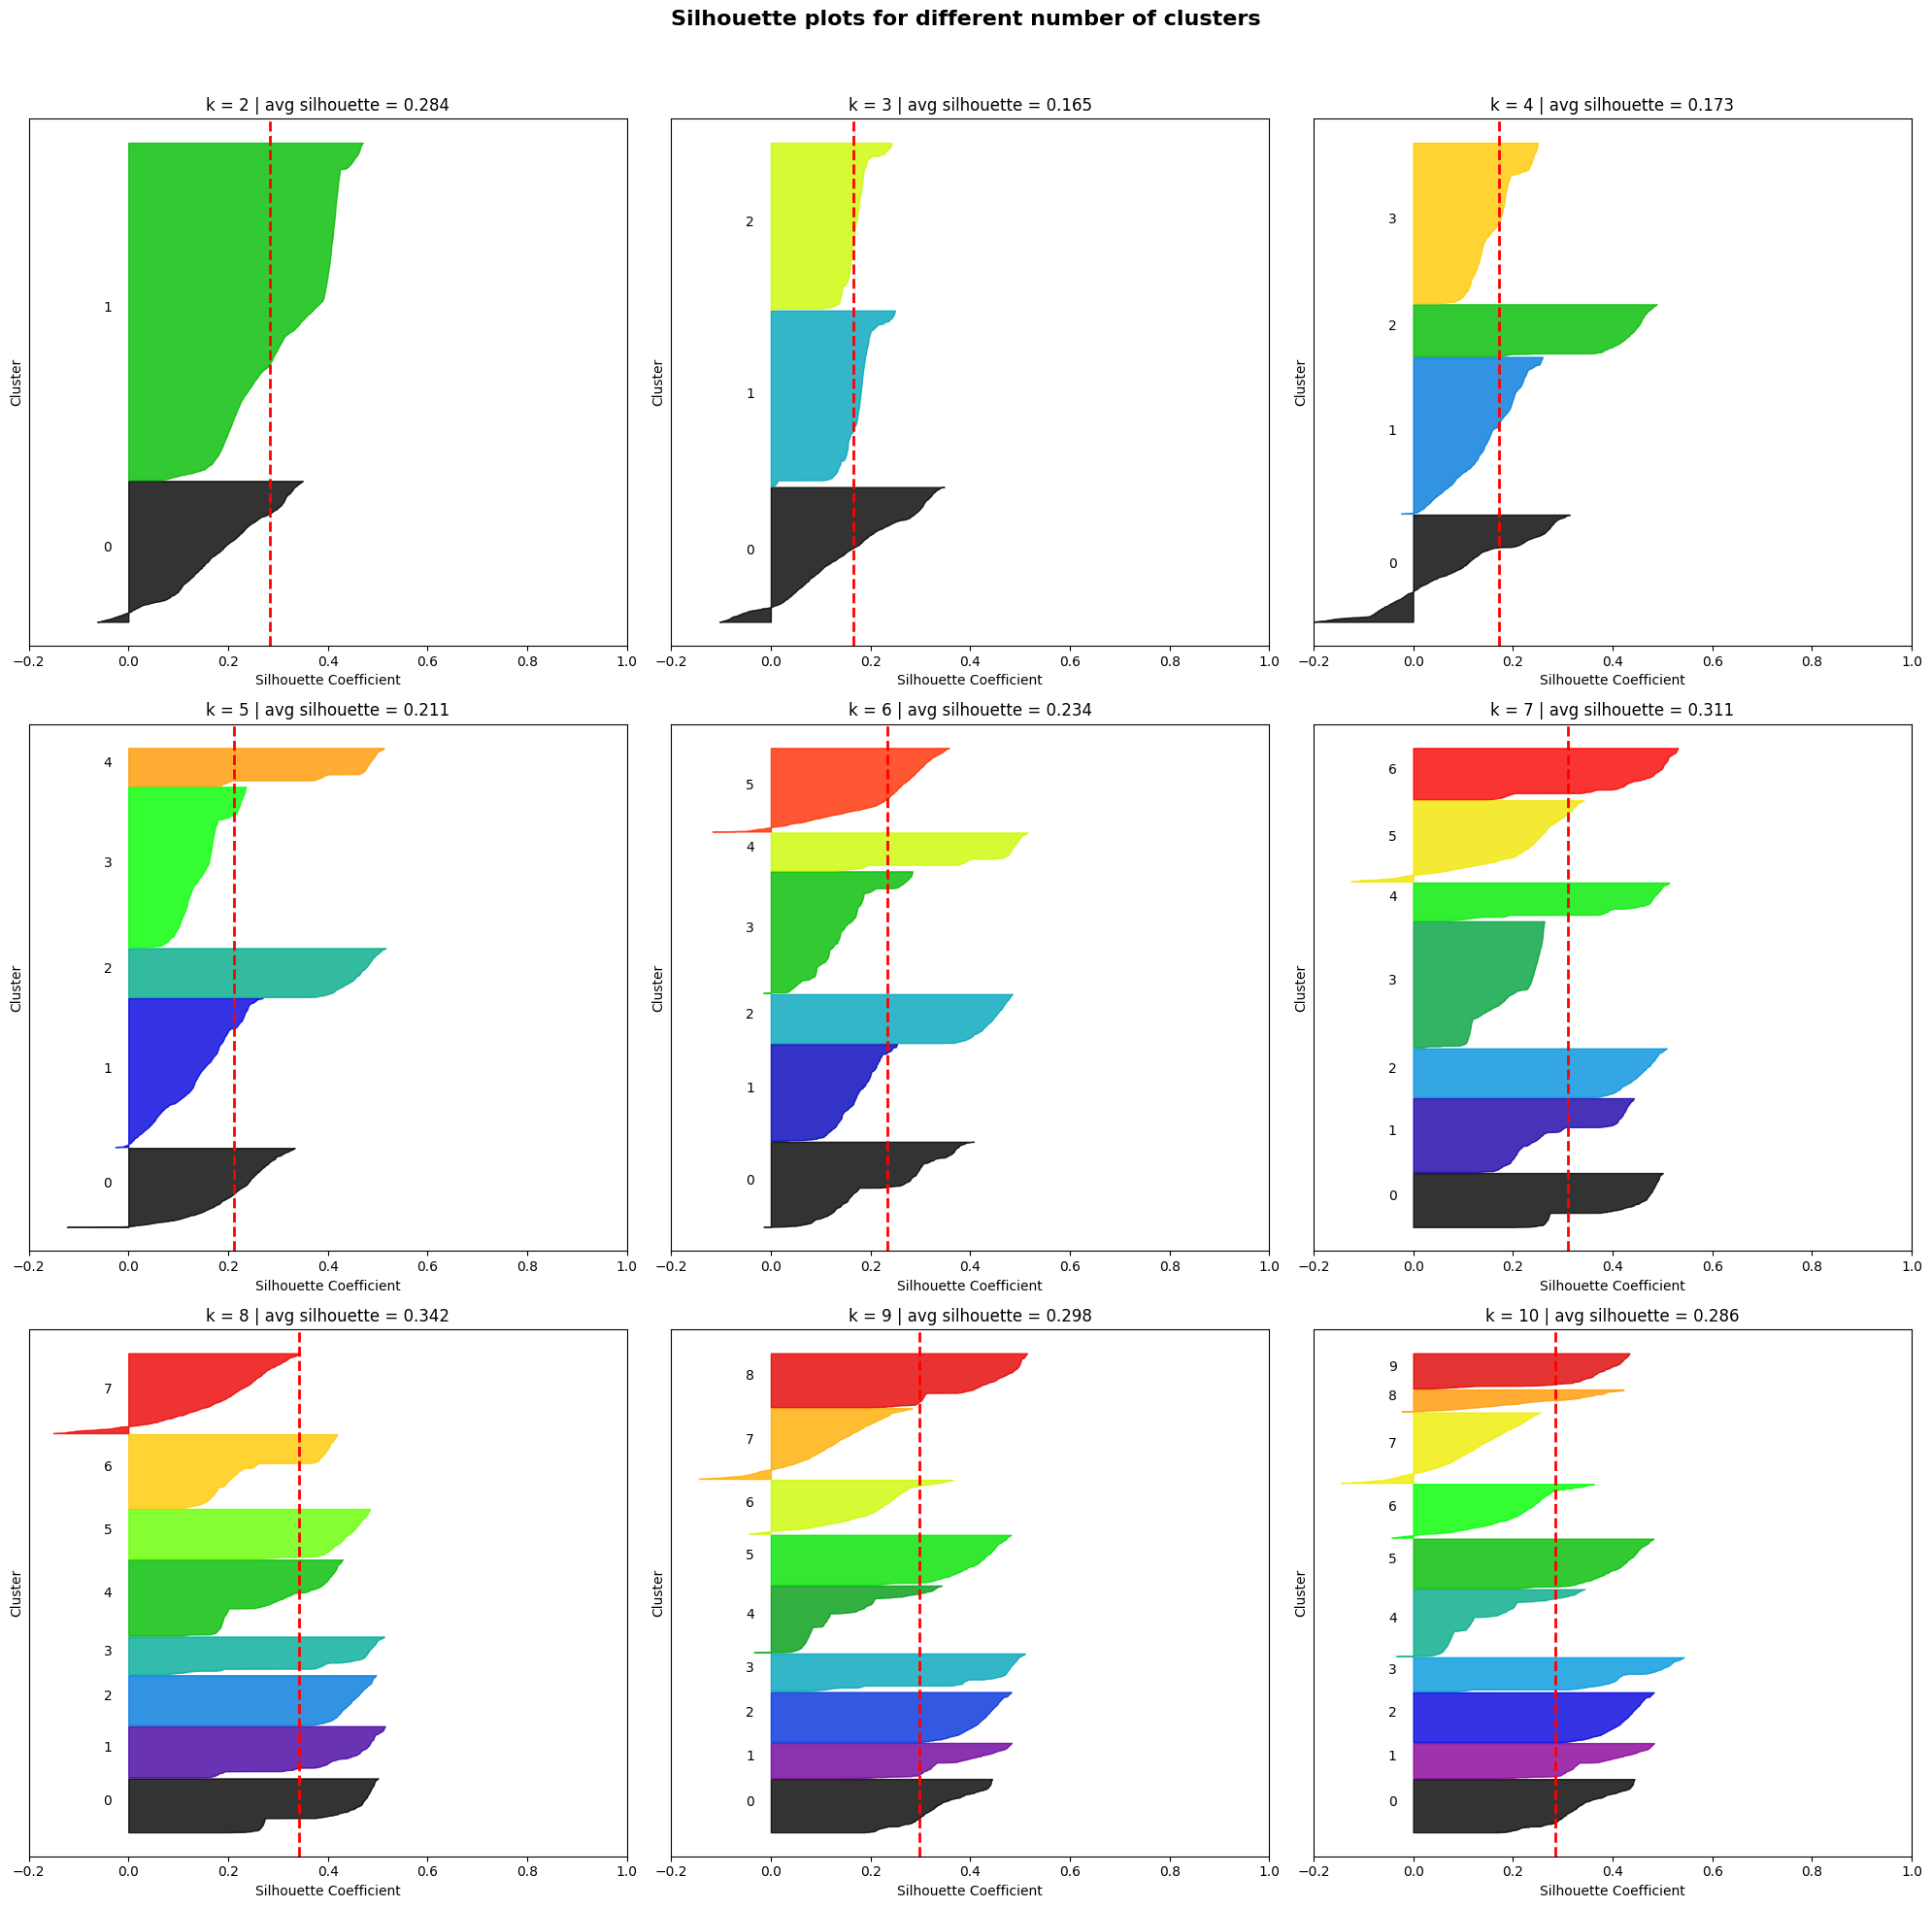

In [ ]:

# Define the different k values to plot
k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Create subplots
fig, axes = plt.subplots(3, 3, figsize=(20, 20))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Generate silhouette plots for each k value using the preprocessed data thats been scaled and encoded but not clustered
for ax, k in zip(axes, k_values):
    silhouette_plot_single(ax, preprocessed, k)

# Add overall title
fig.suptitle('Silhouette plots for different number of clusters', fontsize=16, fontweight='bold')

# Adjust spacing for suptitle
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save figure and show
plt.savefig('../charts/silhouette_plots.png')
plt.show()
